In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mental-health-in-tech-field-datset/mental_health.sqlite


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3 as sql
import plotly.express as px
import plotly.graph_objs as go



In [3]:
path = "/kaggle/input/"
dataset = path +'mental-health-in-tech-field-datset/mental_health.sqlite'
con = sql.connect(dataset)

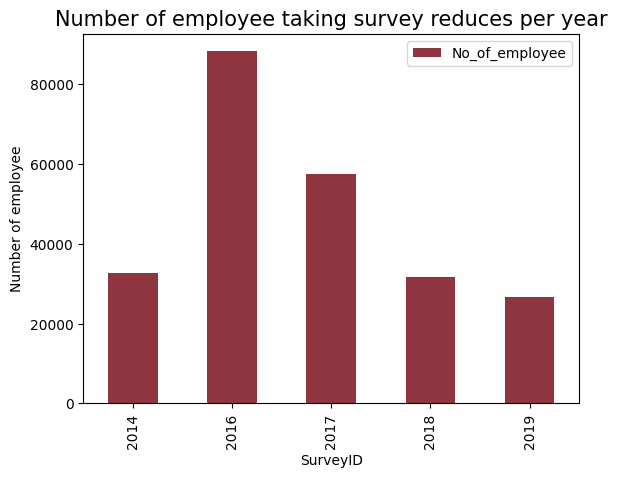

In [4]:
query = """
    Select 
        SurveyID,
        count() as No_of_employee
        from Answer 
        Group by SurveyID;
    """
Employee_per_survey = pd.read_sql(query,con).astype({"No_of_employee":int})
barplot = Employee_per_survey.plot.bar(x='SurveyID', y='No_of_employee',color ='#7A111E',alpha=0.85)
plt.title('Number of employee taking survey reduces per year', fontsize=15)
plt.ylabel('Number of employee')
plt.xlabel('SurveyID')
plt.show()


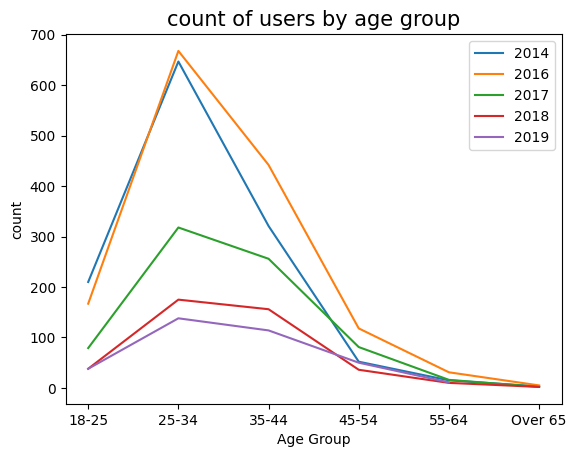

In [5]:
query ="""
    select SurveyID,
        case
            when AnswerText Between 18 And 25 then '18-25'
            when AnswerText between 25 and 34 then '25-34'
            when AnswerText between 35 and 44 then '35-44'
            when AnswerText between 45 and 54 then '45-54'
            when AnswerText between 55 and 64 then '55-64'
            when AnswerText between 65 and 99 Then 'Over 65'
          End as age_group,
         count(*) as count
    from Answer 
    Where SurveyID IN(2014,2016,2017,2018,2019)
           and QuestionID = 1
           and AnswerText >18
    Group By SurveyID, age_group
    order by surveyID, age_group;
    """
Age_Survey = pd.read_sql(query, con)
SurveyID_groups = Age_Survey['SurveyID'].unique()

#create a figure and axis object
fig, ax = plt.subplots()

#plotting line for each age group
for SurveyID_group in SurveyID_groups:
    ax.plot(Age_Survey.loc[Age_Survey['SurveyID']== SurveyID_group,'age_group'],
    Age_Survey.loc[Age_Survey['SurveyID'] == SurveyID_group,'count'], label=SurveyID_group)

#setting x and y axis
ax.set_xlabel('Age Group')
ax.set_ylabel('count')

#title of plot
ax.set_title('count of users by age group',fontsize=15)

#showing legend
ax.legend()

#show graph
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

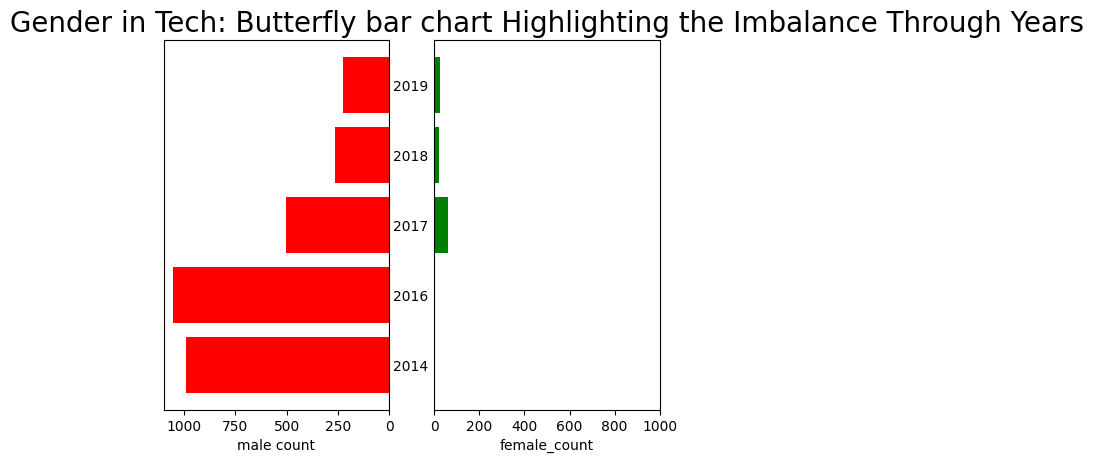

In [6]:
query = """
 Select SurveyID, sum( case when AnswerText='male' or AnswerText='Male' Then 1 else 0 End) as male_count,
 sum(case when AnswerText ='female' or AnswerText = 'female' Then 1 else 0 end) as female_count
 from Answer 
 where QuestionID ==2
 or(QuestionID ==9 and AnswerText ==1)
 or(QuestionID ==3 and AnswerText =='United States of America' OR AnswerText == 'United States')
 group by SurveyID 
 """

#q2: what is your gender?
#q3: is your employer primarily a tech company/organization?
#q3: what country do you live in?
df=pd.read_sql(query, con)
position = np.arange(len(df)) + .5
fig, (ax_left, ax_right)=plt.subplots(ncols=2)
ax_left.barh(position,df['male_count'],align='center',facecolor='red')
ax_left.set_xlim((0,1100))
ax_left.set_yticks([])
ax_left.invert_xaxis()
ax_left.set_xlabel('male count')

ax_right.barh(position, df['female_count'], align ='center', facecolor='green')
ax_right.set_xlim((0,1000))
ax_right.set_yticks(position)
ax_right.set_yticklabels(df['SurveyID'].values, ha='center',x=-0.06)
ax_right.set_xlabel('female_count')
plt.title('Gender in Tech: Butterfly bar chart Highlighting the Imbalance Through Years', fontsize=20)
plt.tick_params(left=False)
plt.show

In [7]:
query = """

SELECT year,company_type,
        COUNT(Mental_Health) AS total_Mental_Health,
        SUM(Mental_Health) AS have_Mental_Health,
        100.0*SUM(Mental_Health)/COUNT(Mental_Health) AS Percentage
FROM (
    SELECT SurveyID AS year,
            MAX(CASE WHEN (QuestionID == 4  AND AnswerText !=-1) THEN AnswerText END) AS state,
            MAX(CASE WHEN (QuestionID == 5  AND AnswerText != 1) THEN AnswerText END) AS Self_Employed,
            MAX(CASE WHEN (QuestionID == 13 AND AnswerText == 1) THEN 'Tech_company' ELSE 'Other_company' END) AS company_type,
            MAX(CASE WHEN (QuestionID == 33 AND AnswerText == 'Yes') THEN 1 ELSE 0 END) AS Mental_Health
    FROM Answer
    WHERE QuestionID IN (4,5,13, 33) AND year != 2014
    GROUP BY year, UserID
    HAVING state IS NOT NULL
       AND Self_Employed IS NOT NULL
) AS mh_data
GROUP BY year,company_type;

"""
df = pd.read_sql(query, con)

trace1 = go.Bar(
    x=df[df['company_type'] == 'Other_company']['year'],
    y=df[df['company_type'] == 'Other_company']['total_Mental_Health'],
    name='Other Company', marker_color= '#D6604D'
)

trace2 = go.Bar(
    x=df[df['company_type'] == 'Tech_company']['year'],
    y=df[df['company_type'] == 'Tech_company']['total_Mental_Health'],
      name='Tech Company',marker_color= '#4393C3'
)
trace3 = go.Scatter(
    x=df[df['company_type'] == 'Other_company']['year'],
    y=df[df['company_type'] == 'Other_company']['Percentage'],
    name='Other Company',
    yaxis='y2',marker_color= '#B2182B'
)

trace4 = go.Scatter(
    x=df[df['company_type'] == 'Tech_company']['year'],
    y=df[df['company_type'] == 'Tech_company']['Percentage'],
    name='Tech Company',
    yaxis='y2',marker_color= '#2166AC'
)

# Define the layout
layout = go.Layout(
    title='Mental Health Comparison by role',
    yaxis=dict(title='Total number of employees'),
    yaxis2=dict(
        title='Percentage of Users with Mental Health',
        overlaying='y',
        side='right',
        range=[0, 100]
    ),
    barmode='group'
)
fig = go.Figure(data=[trace1, trace2, trace3, trace4], layout=layout)

# Show the figure
fig.show()

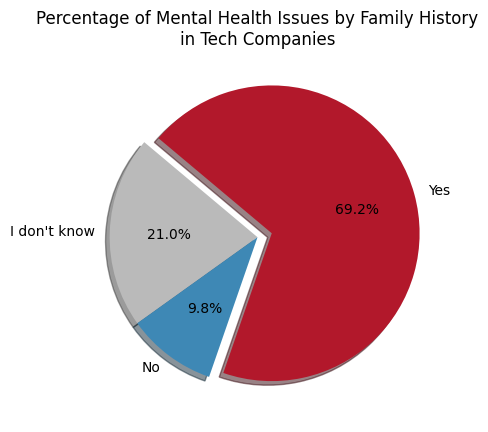

In [8]:
query = """

SELECT family_history,
       100.0 * COUNT(family_history) / SUM(COUNT(family_history)) OVER () AS percentage
FROM (
    SELECT SurveyID AS year,
            MAX(CASE WHEN (QuestionID == 4  AND AnswerText !=-1) THEN AnswerText END) AS state,
            MAX(CASE WHEN (QuestionID == 5  AND AnswerText != 1) THEN AnswerText END) AS Self_Employed,
            MAX(CASE WHEN (QuestionID == 13 AND AnswerText == 1) THEN 'Tech_company' END) AS tech_company,
            MAX(CASE WHEN (QuestionID == 33 AND AnswerText == 'Yes') THEN 1 END) AS Mental_Health,
            MAX(CASE WHEN (QuestionID == 6 ) THEN AnswerText END) AS family_history

    FROM Answer
    WHERE QuestionID IN (4,5,6, 13, 33) AND year != 2014
    GROUP BY year, UserID
    HAVING state IS NOT NULL
       AND Self_Employed IS NOT NULL
       AND tech_company IS NOT NULL
       AND Mental_Health IS NOT NULL
)
GROUP BY  family_history

"""
df = pd.read_sql(query, con)

colors = ["#BABABA", "#3E88B5", "#B2182B"]
explode = (0, 0, 0.1)
plt.pie(df["percentage"], labels=df["family_history"], explode=explode, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.title("Percentage of Mental Health Issues by Family History\n"+"in Tech Companies")
plt.show()

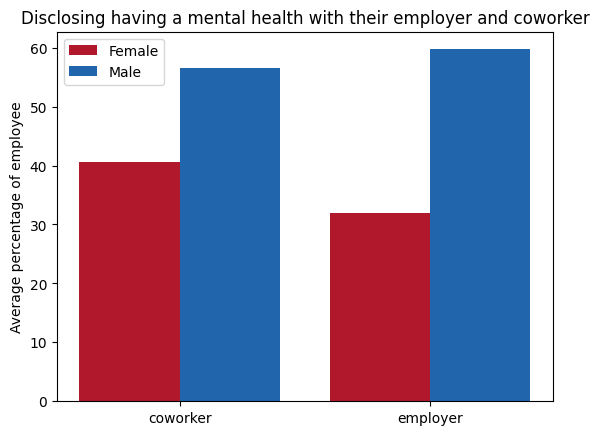

In [9]:
query = """
SELECT Discuss,
       (COUNT(female)*100.0/COUNT()) AS female_Percentage,
       (COUNT(male)*100.0/COUNT()) AS male_Percentage
FROM (
 SELECT UserID,SurveyID AS year,
        MAX(CASE WHEN (QuestionID == 2 AND AnswerText LIKE '%emale%') THEN 1 END) AS female,
        MAX(CASE WHEN (QuestionID == 2 AND AnswerText == 'male' OR AnswerText == 'Male' ) THEN 1 END) AS male,
        MAX(CASE WHEN (QuestionID == 4  AND AnswerText !=-1) THEN AnswerText END) AS state,
        MAX(CASE WHEN (QuestionID == 5  AND AnswerText != 1) THEN AnswerText END) AS Self_Employed,
        MAX(CASE WHEN (QuestionID == 13  AND AnswerText == 1) THEN AnswerText END) AS Tech_company,
    COALESCE(
        MAX(CASE WHEN (QuestionID = 58 AND AnswerText = 1) THEN 'employer'  END),
        MAX(CASE WHEN (QuestionID = 60 AND AnswerText = 1) THEN 'coworker'  END)
         ) AS Discuss,

        COUNT (*) as count

 FROM Answer
 WHERE   QuestionID == 4
         OR QuestionID IN (2,4,5,13, 58,60)


GROUP BY UserID
HAVING state IS NOT NULL
       AND Self_Employed IS NOT NULL
       AND Tech_company IS NOT NULL
)
WHERE year IN (2017, 2018, 2019) AND Discuss != 'None'
GROUP BY Discuss
"""
#Question2: what is your gender?
#Question 4 which state ? to limit the analysis inside the USA
#Question 5 are you self employed?  to limit the analysis to companies
#Question 9: Is your employer primarily a tech company/organization? to limit to tech

df = pd.read_sql(query, con)
X_axis = np.arange(len(df['Discuss']))

plt.bar(X_axis - 0.2, df['female_Percentage'], 0.4, label = 'Female', color = "#B2182B")
plt.bar(X_axis + 0.2, df['male_Percentage'], 0.4, label = 'Male', color = "#2166AC")
plt.xticks(X_axis, df['Discuss'])
plt.ylabel("Average percentage of employee")
plt.title("Disclosing having a mental health with their employer and coworker")
#plt.subtitle("The average percentage of employees disclosing having a mental health disorder to their employer and coworker")
plt.legend()
plt.show()
#Are women more likely than men to report experiencing mental health symptoms?

In [10]:
query = """
SELECT Comfortance,
    SUM(CASE year WHEN 2017 THEN percentage END) AS Y2017,
    SUM(CASE year WHEN 2018 THEN percentage END) AS Y2018,
    SUM(CASE year WHEN 2019 THEN percentage END) AS Y2019
FROM (
    SELECT year, Comfortance,
        COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (PARTITION BY year) AS percentage
    FROM (
        SELECT SurveyID AS year,
        MAX(CASE WHEN (QuestionID == 4  AND AnswerText !=-1) THEN 1 END) AS state,
        MAX(CASE WHEN (QuestionID == 5  AND AnswerText != 1) THEN 1 END) AS Self_Employed,
        MAX(CASE WHEN (QuestionID == 13  AND AnswerText == 1) THEN AnswerText END) AS Tech_company,
        MAX(CASE WHEN (QuestionID == 57) THEN AnswerText END) AS Comfortance,
        COUNT (*) as count

        FROM Answer
        WHERE QuestionID IN (4, 5, 13, 57)
         GROUP BY UserID, SurveyID
        HAVING state IS NOT NULL
               AND Self_Employed IS NOT NULL
               AND Tech_company IS NOT NULL
    ) AS t
    GROUP BY year, Comfortance
) AS t2

GROUP BY Comfortance

"""

df = pd.read_sql(query, con)
comfortance_colors = {
    'Mental health': '#2166AC',
    'Physical health': '#D6604D',
    'Same level of comfort for each': '#FFDAB9'
}

# Create a list of colors for each value in the 'Comfortance' column
colors = [comfortance_colors[x] for x in df['Comfortance'].dropna()]
# Set the colors for the pie chart
#colors = ['#FFDAB9', '#D6604D', '#2166AC']

# Create the figure
fig = go.Figure()

# Add the traces for each year
for year in df.columns[1:]:
    # Filter out the NaN values
    data = df[['Comfortance', year]].dropna()
    fig.add_trace(go.Pie(labels=data['Comfortance'],
                         values=data[year],
                         hole=.5,
                         name=str(year),
                         marker_colors=colors))

# Update the layout
fig.update_layout(
    title="Comfort Levels for Mental and Physical Health Discussions",
    updatemenus=[go.layout.Updatemenu(
        active=0,
        buttons=list([ dict(label="Y2017",
                 method="update",
                 args=[{"visible": [True, False, False]},
                       {"title": "Comfort Levels for Mental and Physical Health Discussions in 2017",'showactive':True}]),
            dict(label="Y2018",
                 method="update",
                 args=[{"visible": [False, True, False]},
                       {"title": "Comfort Levels for Mental and Physical Health Discussions in 2018",'showactive':True}]),
            dict(label="Y2019",
                 method="update",
                 args=[{"visible": [False, False, True]},
                       {"title": "Comfort Levels for Mental and Physical Health Discussions in 2019",'showactive':True}])
        ])
    )
])
fig.update_traces(marker=dict(colors=colors, line=dict(color='#000000', width=2)))

fig.show()
        